# Requests API (`.requests`)

Estimated reading time: 5'

## What you'll learn

This guide's objective is to explain the usage of requests in the collaboration between the data owners and data scientists.

## Introduction

A data owner's role is to decide how access to their server and assets (such as datasets or models) takes place. However, instead of pre-emptively restricting everything a data scientist can do to a set of allowed actions, PySyft enables more flexibility by allowing the data scientist to request very specific changes in what they are permissioned to do. These are called `requests`.

## How are requests structured?


### Request Components

A request has two main functional components:
- a `sy.Change`, which is the subject of the request (`request.changes`). This is explained in more detail below.
- a `sy.RequestStatus`, which is whether the change was or not applied. It can be `Approved`, `Pending` or `Denied`. (`request.status`)

### Request Workflow

In general, the workflow of a requests within PySyft consists of:
- (1) **submission**: a request is created on the appropriate API (e.g. `client.code`, `client.images`), stating the desired output. 
- (2) **review & approval**: the request must be appropriately reviewed by the data owner to understand the implications of approving the request from a security and privacy standpoint. A data owner could decide to approve or deny. If approved, the changes proposed as part of the request are applied to the indended object. 
- (3) **changes are aplied**: if approved, the changes applied are visible back to the requesting data scientist. 

An example is given below for the code requests. All requests follow the same pattern of execution. 

<div align="center">
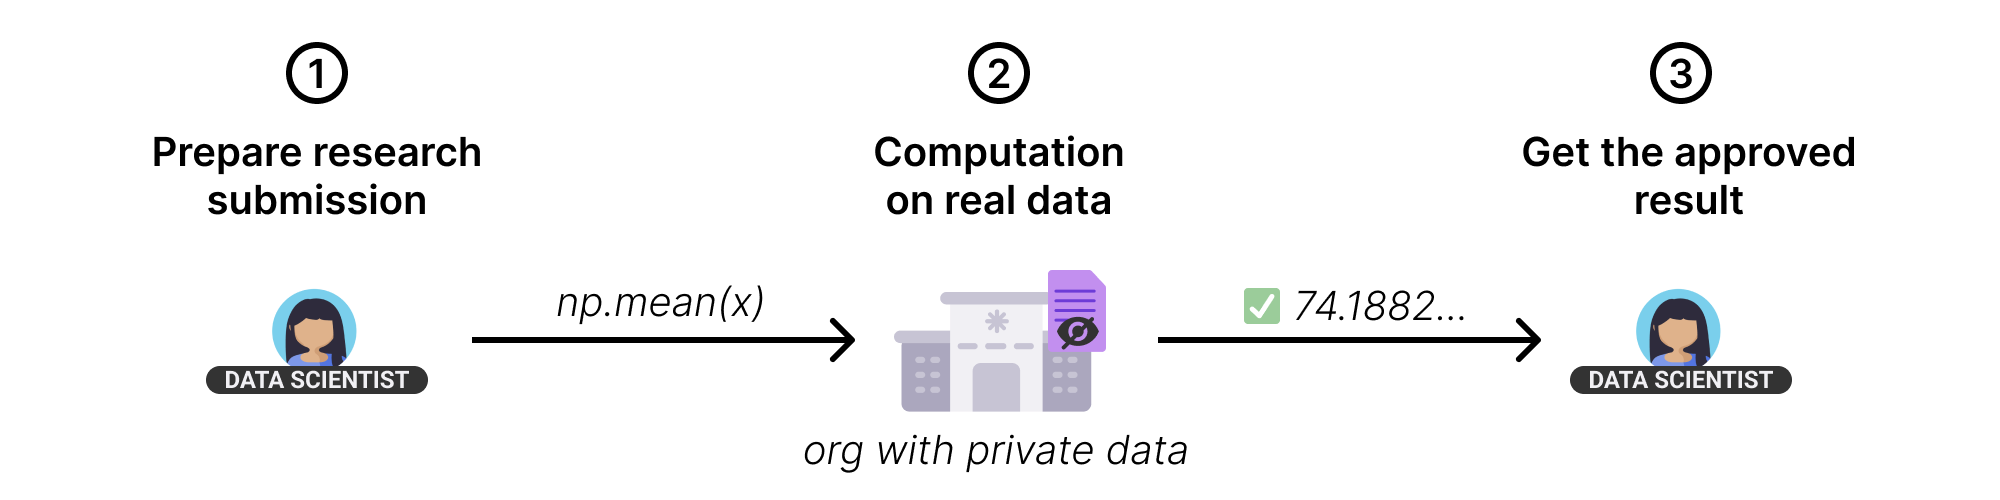
</div>

### Types of requests & changes

Requests can be initiated by a user of the server and depending on the type of the request, they contain a pre-defined "change". A `sy.Change` links an existing Syft Object (`change.linked_obj`) and encapsulates a specific type of alteration of that object. Whilst the above is sightly abstract, a few types of requests are currently available in PySyft, with the help of changes:

- **Code Requests**: these requests used the most common type of change, called `UserCodeStatusChange`, which allows data scientists to request the permission to execute a specific Syft Function (available via `request.code`). Concretely, when a [UserCode](./code-api.ipynb) is paired with specific [Syft Policies](./syft-policies.ipynb), the user can request the permission to execute that code within the bounds permitted by the Input and Output policies attached. Such policies must state, at minimum, the asset on which the computation intended for and how many times it can be executed. 

```{admonition} Execution Permissions on a Low-side server
Such permissions for execution are useful only when a data scientist has direct access to the server in which the private data is stored. In the case of a low-side server, the data scientist will be interfacing with a `SyncedUserCodeStatusChange` that only allows to retrieve execution output, rather than executing the code themselves, due to the airgap implied by the system and the lack of the linked obj on the server.
```

- **Custom Worker Pool Requests**:  these requests rely on `CreateCustomWorkerPoolChange` change, which allows data scientists to request the creation of a new resource on the server, namely a worker pool, from an existing custom image on the server, so that data scientists can execute their code in a container running the desired Python packages and possibly allow them to scale even further depending on the worker pool's size proposed. Note that here, requests are also able to launch resources. More about this coming soon in the [images API guide](#TODO).

- **Custom Image & Worker Pool Requests**: these requests imply two changes: `CreateCustomImageChange` and `CreateCustomWorkerPoolChange`. This allows data scientists not only to create a custom worker pool from an image, like the request above, but also to specify a new image definition alongside with their desired software, in case the existing images do not fullfill their needs. 

- **Association Requests**: these requests imply a `AssociationRequestChange` change, which allows a data owner to submit a request on an external Datasite server to create an unidirectional route to communicate with that server. This requires approval from the external data owner that owns that server. More about this coming soon in the [networking guide](#TODO).

- **Action Object Permission Request**: these requests imply a `ActionStoreChange` change, which allows data scientists to request `READ` permissions on a specific `ActionObject` available on the server, which is the wrapper object for data that is being stored in PySyft or generated out of computations. More about this coming soon in the [action API guide](#TODO).

Let's see now how one can create a code request. We will shortly document how to create the other types of requests, as the rest of the requests are currently under beta.

## Create a code request



We will first run some setup code to enable the code request creation.

In [ ]:
import numpy as np
import syft as sy

server = sy.orchestra.launch(name="my_server", port="auto", dev_mode=False, reset=True)
do_client = server.login(email="info@openmined.org", password="changethis")
do_client.register(
    email="newuser@openmined.org", name="John Doe", password="pw", password_verify="pw"
)
ds_client = server.login(email="newuser@openmined.org", password="pw")

dataset = sy.Dataset(
    name="Dataset name",
    description="**Placehoder Dataset description**",
    asset_list=[sy.Asset(
        name="asset_name",
        data=[1,2,3], # real data
        mock=[4,5,6], # mock data
    )],
)

do_client.upload_dataset(dataset)

By inspecting the [code API guide](./code-api.ipynb), we can construct a dummy Syft Function to include in our request:

In [ ]:
@sy.syft_function_single_use(x=ds_client.datasets[0].assets[0])
def my_dummy_func(x):
    return x+1

### Ways to create a code request

There are currently two ways to create such code execution requests in PySyft:

1. Directly via the Code API
2. Within a Project's Scope

#### Directly via the Code API

In [ ]:
ds_client.code.request_code_execution(my_dummy_func)

#### Within a project's scope

In [ ]:
# Create a project
project = sy.Project(
    name="Dummy project",
    description="I am doing a dummy project for illustrating code requests.",
    members=[ds_client],
).send()

project

In [ ]:
project.create_code_request(my_dummy_func)

## View requests

All requests, regarding of their type and purpose, can be viewed under the `Requests` API exposed by PySyft. 

As with other APIs, an admin or data owner can see all requests submitted to their server, whilst a data scientist can only see the ones that they submitted:

In [ ]:
ds_client.requests

We can index into each individual request as such:

In [ ]:
request = ds_client.requests[0]

request

If curious, you can also see the exact change type and the linked object to the change:

In [ ]:
request.changes[0]

In [ ]:
request.changes[0].linked_obj

### Request Metadata

Further metadata is available on a `sy.Request` object, such as:
- who created the request:
    - `requesting_user_name`: the user that created the request
    - `requesting_user_email`: the email of the requesting user
    - `requesting_user_institution`: the institution of affiliation of the requesting user
    - `requesting_user_verify_key`: the system generated verify key of the requesting user

- when it was modified:
    - `request_time`: the time when the request was created
    - `updated_at`: the time when the request was updated last (e.g. its status)
    - `history`: contains a log of the request's status changes

- where it was created:
    - `server_uid`: the UID of the server on which the request was created

- who approved the request:
    - `request.approving_user_verifying_key`: the system generated verify key of the approving user


In [ ]:
ds_client.requests[0].changes[0].linked_obj

## Responding to a request

Only an admin or data owner have the permission of approving or denying a request. 

It is their responsaibility to make sure that approval is not imposing privacy or security concerns and that it is aligned with their internal rules for releasing data. In case they are not, the data owner are able to deny the requests. 

### Review step

In [ ]:
do_client.requests[0]

In [ ]:
request = do_client.requests[0]
request.code

### Approval step

This is possible via the `.approve` and `.deny` APIs. However, please note that code requests **might behave** differently depending on the deployment setup. If the setup consists only of one server containing both the mock and private data (a high-side node), the data owner can directly proceed with:


In [ ]:
request.approve()

Or deny:

In [ ]:
request.deny(reason="This imposes privacy risks")

However, when the request is created on an air-gapped system, the approval is implicit part of the syncing flow, whilst the denial is taking place similarily, where the request was created (on the low-side). You can read more about the whole flow in the [syncing API](./syncing-api.ipynb).